In [1]:

import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_context('talk')
import os
import sys

%pylab inline
pylab.rcParams['figure.figsize'] = (14, 6)

PROJ_ROOT = os.path.join(os.pardir)

Populating the interactive namespace from numpy and matplotlib


In [2]:
%load_ext watermark
%watermark -a "BD" -v -p numpy,pandas

BD 

CPython 3.7.3
IPython 7.7.0

numpy 1.16.4
pandas 0.25.0


# Exploratory data analysis

In [3]:
#load files
driver_data = os.path.join(PROJ_ROOT, 
                         'data',
                         'driver_ids.csv')

rides_data = os.path.join(PROJ_ROOT, 
                         'data',
                         'ride_ids.csv')

rides_timestamps = os.path.join(PROJ_ROOT, 
                         'data',
                         'ride_timestamps.csv')

driver_df = pd.read_csv(driver_data, index_col = 'driver_onboard_date', parse_dates = True)
driver_df.sort_index(inplace = True) #sort the timestamp index

rides_df = pd.read_csv(rides_data)

rides_ts_df = pd.read_csv(rides_timestamps, index_col = 'ride_picked_up_at', parse_dates = True)
rides_ts_df.sort_index(inplace = True) #sort the timestamp index

### driver_ids dataframe

In [4]:
driver_df.head(2)

,driver_id
driver_onboard_date,
2016-03-28,72ca99bb6667024a23e1f68904b06fd0
2016-03-28,f86eb77e1cefe28e9f0e9d3775fae261


In [5]:
driver_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 937 entries, 2016-03-28 to 2016-05-15
Data columns (total 1 columns):
driver_id    937 non-null object
dtypes: object(1)
memory usage: 14.6+ KB


- No null values prior to using onboarding date the index
- data range from 3/28 - 5/15, these values along dates provided for rides will be useful in defining churn

### ride_ids dataframe

In [6]:
rides_df.head(2)

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,50
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0


In [7]:
rides_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193502 entries, 0 to 193501
Data columns (total 5 columns):
driver_id          193502 non-null object
ride_id            193502 non-null object
ride_distance      193502 non-null int64
ride_duration      193502 non-null int64
ride_prime_time    193502 non-null int64
dtypes: int64(3), object(2)
memory usage: 7.4+ MB


In [8]:
rides_df.describe()

,ride_distance,ride_duration,ride_prime_time
count,193502.000000,193502.000000,193502.000000
mean,6955.218266,858.966099,17.305893
std,8929.444606,571.375818,30.825800
min,-2.000000,2.000000,0.000000
25%,2459.000000,491.000000,0.000000
50%,4015.000000,727.000000,0.000000
75%,7193.000000,1069.000000,25.000000
max,724679.000000,28204.000000,500.000000


- there is a min ride distance of '-2' in the data. There is no information in the description labeling negative numbers as NaN values. All rows with negatives will be removed

In [9]:
rides_df[rides_df.ride_distance < 0]

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time
68704,569271b82c506166a23ffcfbf6f854f2,ff1ca66337a18055f1c70c7645399972,-2,181,50


In [10]:
rides_df = rides_df[~rides_df.ride_distance < 0]

- No null values
- Negative values removed
- Definition of Prime Time is vauge, unsure of if this is a currency value added to the ride, a multiplier, or some other value.

### ride_timestamps dataframe

In [11]:
rides_ts_df.head(2)

,ride_id
ride_picked_up_at,
2016-03-28 06:02:39,655ccbeb2a62880159e20e986c1cdaeb
2016-03-28 08:14:13,e81c8bdc2a6a9056ba49bf67bf97c311


In [12]:
rides_ts_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 194081 entries, 2016-03-28 06:02:39 to 2016-06-27 00:02:06
Data columns (total 1 columns):
ride_id    194081 non-null object
dtypes: object(1)
memory usage: 3.0+ MB


- No null values
- date range is from 3/28 (the same start up date) to 6/27. 3 Months of data. 
    - The longest time period here would be 3 months of data after a driver became 'activated'
    - Ideally I would like to have a longer period of data. Say 6 months to a year of data, to have a longer test period defining churn. 
    - Many drivers use ride share programs between jobs, or as supplemental income, giving some irregularity in when they would log in. Having a longer period defining churn (say a month) may prove a better definition of churn.
    

# Experiment & Metrics Design

In [13]:
driver_df.reset_index(inplace = True)
df = pd.merge(driver_df, rides_df, on = 'driver_id')

In [14]:
rides_ts_df.reset_index(inplace = True)
df = pd.merge(rides_ts_df, df, on = 'ride_id')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 184208 entries, 0 to 184207
Data columns (total 7 columns):
ride_picked_up_at      184208 non-null datetime64[ns]
ride_id                184208 non-null object
driver_onboard_date    184208 non-null datetime64[ns]
driver_id              184208 non-null object
ride_distance          184208 non-null int64
ride_duration          184208 non-null int64
ride_prime_time        184208 non-null int64
dtypes: datetime64[ns](2), int64(3), object(2)
memory usage: 11.2+ MB


In [16]:
df['trips'] = 1

In [17]:
df.groupby('driver_id')['trips'].sum().sort_values()

driver_id
7ff85c5c0e9324e28d1e0d0589c364bd      3
7b625f643d0775f0ac4898e33235377b      3
6df6c8f8d3c2a93314245a604c02bed1     16
706466935b9e1d04e4e116be7ce90ea9     19
fd831ca1d79ae5c6fc3a679a22e5b8cf     19
                                   ... 
3788dc9e91f1548816ce8b5af07ddadc    783
689bdf87fb2de49f98bf4946cfaa5068    794
844e9be5a30d8d9c1f8e9ddb086ff717    821
4eb382d1f7d50fae1294964263d1ce82    831
5ccc0e6dc9c7475caf785cdce7b8eb7a    919
Name: trips, Length: 837, dtype: int64

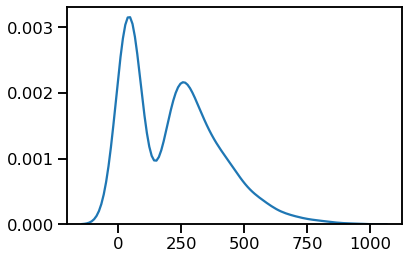

In [18]:
sns.kdeplot(df.groupby('driver_id')['trips'].sum().values)

 - The number of trips is bimodal. Possibly those that are 'full time' and those that are 'part time'
 - Would be interesting & challenging to tease out the 'part time' drivers and the 'churned' drivers

In [19]:
from collections import defaultdict
activated_date= defaultdict(lambda:0)


for i in set(df.driver_id):
    dates = df[df.driver_id == i].ride_picked_up_at
    activated_date[i]=dates.iloc[0]

df['activated_date'] = df.driver_id.map(activated_date)

In [20]:
df['days_since_activated'] = df.ride_picked_up_at - df.activated_date

In [21]:
df.days_since_activated = df['days_since_activated'].apply(lambda x:x.days)

In [22]:
df['since_last_trip'] = df.ride_picked_up_at.max() - df.ride_picked_up_at
df.since_last_trip = df['since_last_trip'].apply(lambda x:x.days)

In [23]:
df['prime_ride_flag'] = df['ride_prime_time'].astype('bool')*1

In [24]:
df = df[df.days_since_activated >= 21]

In [25]:
df['wkday']=[int(datetime.datetime.strftime(x, "%w")) for x in df.ride_picked_up_at]
df['wkday']=[1 if x in np.arange(1,6) else 0 for x in df.wkday]

In [26]:
wkday = defaultdict(lambda:0)

for i in set(df.driver_id):
    day_rides = df[df.driver_id == i].wkday
    sum_rides = df[df.driver_id == i].wkday.sum()
    num_rides = len(df[df.driver_id == i].wkday)
    wkday[i] = sum_rides / num_rides

In [27]:
def day_of_week(row):
    '''function to add in a weekday or weekend label'''
    if row['day'] in ['Sat', 'Sun']:
        return 'Weekend'
    else:
        return 'Weekday'

In [28]:
tsmp_df = df[['trips', 'ride_picked_up_at', 'ride_prime_time']].set_index('ride_picked_up_at')

day_tsmp = tsmp_df.loc['2016-04-19' : '2016-04-25']
day_tsmp = day_tsmp.resample('60T', label = 'left').sum()

tsmp_df = tsmp_df.resample('15min', label = 'left').sum()
tsmp_df['day'] = [datetime.datetime.strftime(x, "%a") for x in tsmp_df.index]

In [29]:
# add a column of 'hour'
tsmp_df['hour'] = [datetime.datetime.strftime(x, "%H:%M:%S") for x in tsmp_df.index]
#add in a weekday or weekend label
tsmp_df['day_type'] = tsmp_df.apply(day_of_week, axis = 1)

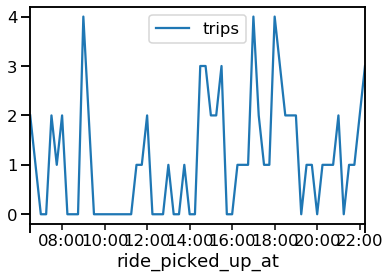

In [30]:
test = df[(df.ride_picked_up_at >'2016-04-20') & (df.ride_picked_up_at <'2016-04-21') ]
test.set_index('ride_picked_up_at', inplace = True)
test = test.sort_index()
test[test.ride_prime_time > 0][['trips']].resample('15min', label = 'left').sum().plot()

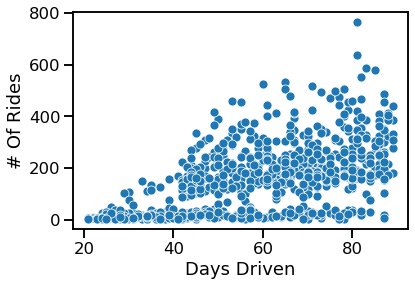

In [31]:
tmp = pd.merge(df.groupby('driver_id')[['days_since_activated']].max(),
         df.groupby('driver_id')[['trips']].sum(),
         left_index = True,
         right_index = True)
sns.scatterplot(x = 'days_since_activated', y = 'trips', data = tmp)
_=plt.xlabel('Days Driven')
_=plt.ylabel('# Of Rides')

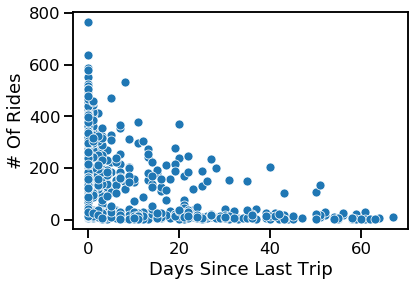

In [32]:
tmp = pd.merge(df.groupby('driver_id')[['since_last_trip']].min(),
         df.groupby('driver_id')[['trips']].sum(),
         left_index = True,
         right_index = True)

sns.scatterplot(x = 'since_last_trip', y = 'trips', data = tmp)
_=plt.xlabel('Days Since Last Trip')
_=plt.ylabel('# Of Rides')

In [33]:
weeks_active = pd.DataFrame(df.groupby('driver_id')['ride_picked_up_at'].max() - df.groupby('driver_id')['activated_date'].min(), columns = ['weeks_active'])
weeks_active.weeks_active = round(weeks_active.weeks_active / pd.to_timedelta('7D'))

ttl_trips = pd.DataFrame(df.groupby('driver_id')[['trips']].sum())

ttl_rides_df = weeks_active.join(ttl_trips)
ttl_rides_df.rename(columns={'trips':'ttl_trips'}, inplace = True)

ttl_rides_df.weeks_active = ttl_rides_df.weeks_active.replace(0,1)
ttl_rides_df['wkly_trips'] = ttl_rides_df['ttl_trips'] / ttl_rides_df['weeks_active']

ttl_rides_df['wkday_pct'] = ttl_rides_df.index.map(wkday)

In [34]:
def segments(x):
    if x < 60:
        return 'segment 1'
    else:
        return 'segment 2'

In [35]:
ttl_rides_df['trips_60'] = ttl_rides_df.ttl_trips.apply(segments)

In [36]:
ttl_rides_df['wkday_pct'] = ttl_rides_df.index.map(wkday)

In [37]:
tmp = df.groupby('driver_id')['trips', 'prime_ride_flag'].sum()
tmp['pct_prime'] = tmp['prime_ride_flag'] / tmp['trips']
ttl_rides_df = pd.merge(tmp[['pct_prime']], ttl_rides_df, left_index = True, right_index = True)

In [38]:
tmp = df.groupby('driver_id')['trips', 'ride_distance'].sum()
tmp['dist_p_ride'] = tmp['ride_distance'] / tmp['trips']
ttl_rides_df = pd.merge(tmp[['dist_p_ride']], ttl_rides_df, left_index = True, right_index = True)

In [39]:
tmp = df.groupby('driver_id')['trips', 'ride_duration'].sum()
tmp['dur_p_ride'] = tmp['ride_duration'] / tmp['trips']
ttl_rides_df = pd.merge(tmp[['dur_p_ride']], ttl_rides_df, left_index = True, right_index = True)

Text(0.5, 0, 'Total Trips')

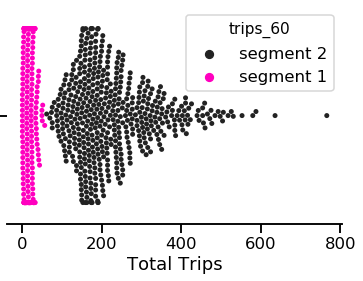

In [40]:
sns.swarmplot(x = ttl_rides_df['ttl_trips'], hue = ttl_rides_df['trips_60'], y = ['']*len(ttl_rides_df), color = '#FF00BF')
sns.despine(left=True, right=True)
plt.xlabel('Total Trips')

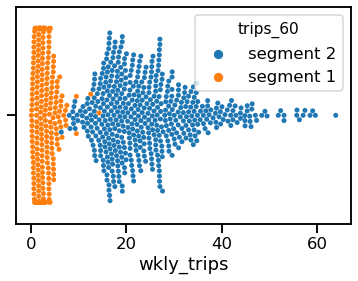

In [41]:
sns.swarmplot(x=ttl_rides_df['wkly_trips'], hue = ttl_rides_df['trips_60'], y = ['']*len(ttl_rides_df))

In [42]:
# how many rides have there been from each driver 3 weeks prior to the end of the dataset?
#Of the more active drivers to find how many rides would be needed to be determined 'churned'

active = defaultdict(lambda:0)

pt = df.ride_picked_up_at.max() - pd.to_timedelta('21D')

for i in ttl_rides_df[ttl_rides_df.trips_60 == 'segment 2'].index:
    dates = df[df.driver_id == i].ride_picked_up_at
    dates = dates[dates>pt]
    dates = set([date.strftime('%Y-%m-%d') for date in dates])
    active[i] = len(dates)



In [43]:
# n of rides in the first 30 days
first_30 = defaultdict(lambda:0)

month = pd.to_timedelta('30D')

for i in set(df.driver_id):
    dates = df[df.driver_id == i].ride_picked_up_at#.to_frame().iloc[-1][0]
    first_ride = dates.iloc[0]
    dates = dates[(dates>=first_ride) & (dates < first_ride + month)]
    first_30[i] = len(dates)

ttl_rides_df['trips_in_first_30'] = ttl_rides_df.index.map(first_30)

#### In the 3 weeks since the last day of the dataset, visualize how many rides have there been among 'active' drivers?

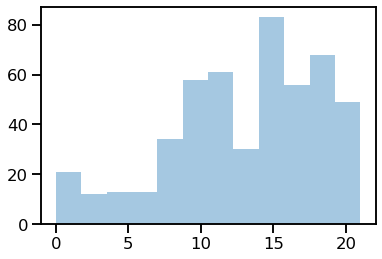

In [44]:
sns.distplot(list(active.values()), hist = True, kde = False)

#### Visualize how many days there have since the drivers last ride given

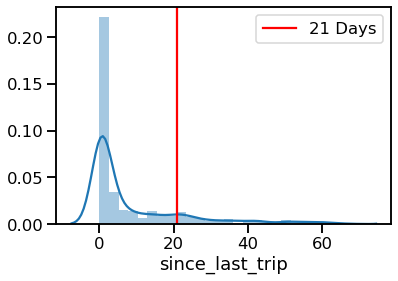

In [45]:
sns.distplot(df.groupby('driver_id')['since_last_trip'].min(),hist = True)
plt.axvline(x=21, color = 'red', label = '21 Days')
plt.legend()
_=plt.show()

### Among the 'active' drivers, find the signicant low value of days since their last trip

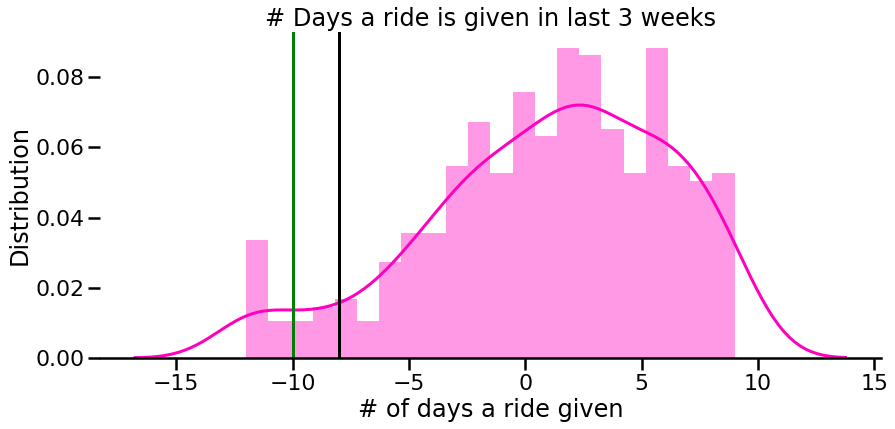

In [46]:
import seaborn as sns; sns.set_context('poster')
pylab.rcParams['figure.figsize'] = (14, 6)
from scipy import stats
z = np.abs(stats.zscore(array(list(active.values()))))

days_mean = int(np.mean(array(list(active.values()))[(z<3)]))
#days_variance = np.var(list(active.values()))

new_array = (array(list(active.values()))[(z<3)] - days_mean)#/ days_variance

sns.distplot(new_array,hist = True, bins = 22, color = '#ff00bf')
plt.axvline(x=-10, color = 'green', label = (-1*(np.std(new_array)*2)))
plt.axvline(x=-8, color = 'black', label =7)
plt.title('# Days a ride is given in last 3 weeks')
plt.xlabel('# of days a ride given')
plt.ylabel('Distribution')
sns.despine(left=True, right=True)

In [47]:
stat, p = stats.normaltest(new_array)
print ('P-Value:', p)

P-Value: 2.0306727641125798e-06


In [48]:
std = np.std(new_array)*2
std

10.550071621824442

In [49]:
cutoff = (-10 + days_mean)
cutoff

2

 - 1.5 days is the significant value, i've rounded up to 2 days
 - I would suggest moving this value to 4 days to be proactive and try to influence drivers before they become churned
 - data analysis will continue with 2 days
     - 'Churned' will be defined as drivers who have only had 2 rides or less in 21 days

In [50]:
active = defaultdict(lambda:0)

pt = df.ride_picked_up_at.max() - pd.to_timedelta('21D')

for i in set(ttl_rides_df.index):
    dates = df[df.driver_id == i].ride_picked_up_at
    dates = dates[dates>pt]
    dates = set([date.strftime('%Y-%m-%d') for date in dates])
    active[i] = len(dates)

In [51]:
def churn(x):
    if x <= cutoff:
        return 'churned'
    else:
        return 'active'

In [52]:

ttl_rides_df['days_taken_3w'] = ttl_rides_df.index.map(active)
ttl_rides_df['churned'] = ttl_rides_df.days_taken_3w.apply(churn)

In [53]:
len(df)

118961

In [54]:
ttl_rides_df.churned.value_counts(normalize = True)

active     0.721785
churned    0.278215
Name: churned, dtype: float64

 - 28% of drivers in the dataset are considered churned

In [55]:
df = pd.merge(df, ttl_rides_df, left_on = 'driver_id', right_index = True )

In [56]:
def plot_ecdf(data, col):
    x = np.sort(data)
    y = np.arange(1, len(x)+1) / len(x)
    _=plt.plot(x, y, marker = '.', linestyle = 'none')
    _=plt.title(col)
    plt.show()

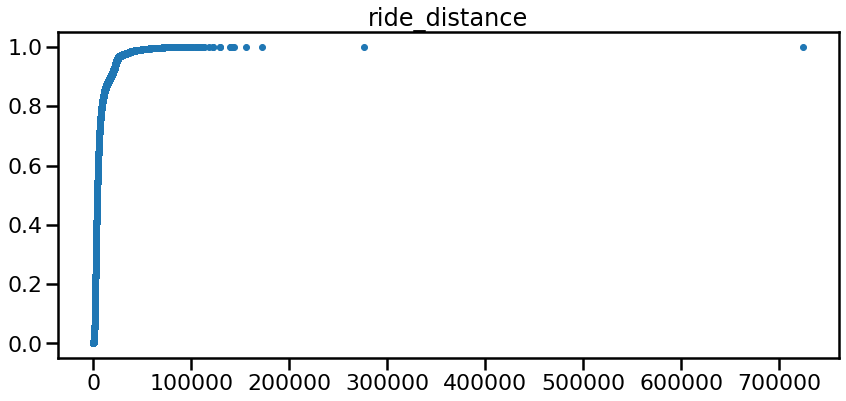

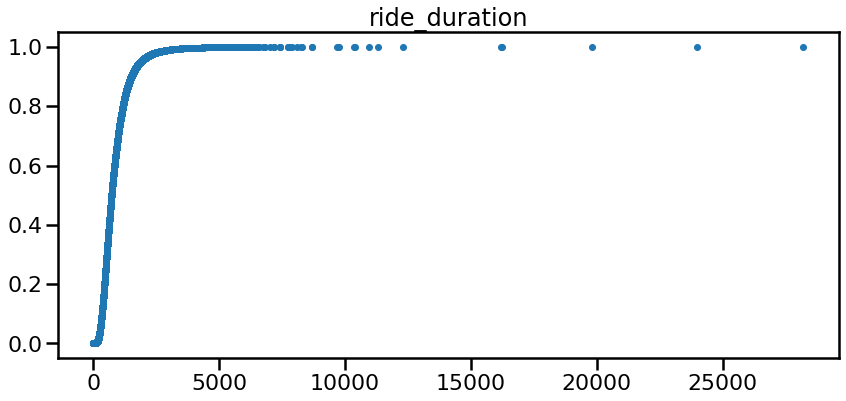

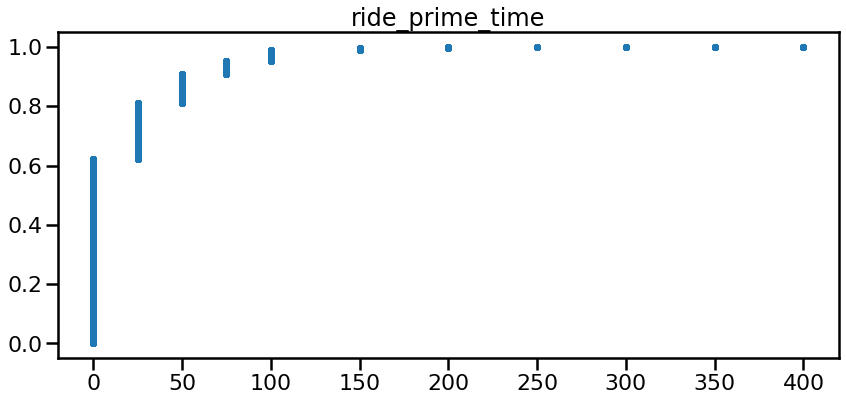

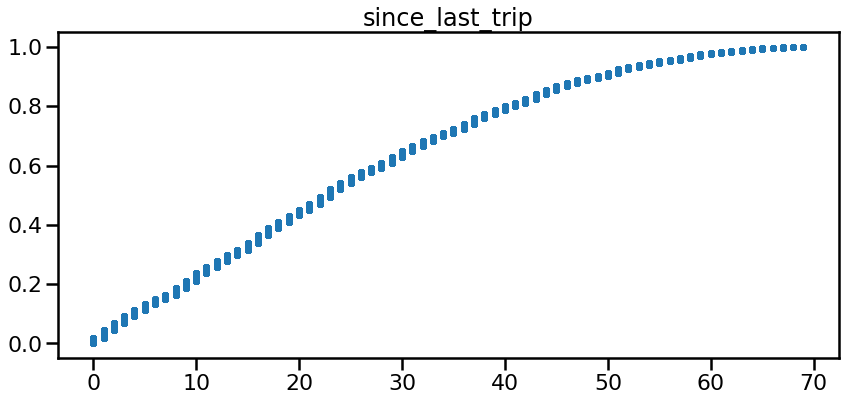

In [57]:
cols = ['ride_distance', 'ride_duration', 'ride_prime_time', 'since_last_trip']
for col in cols:
    plot_ecdf(df[col], col)

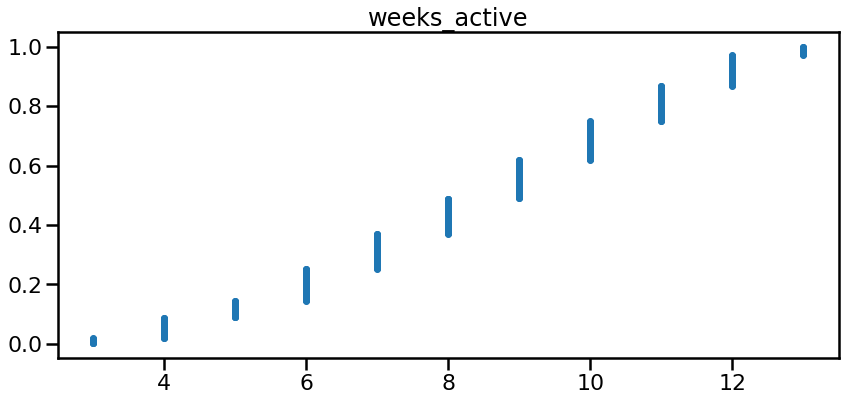

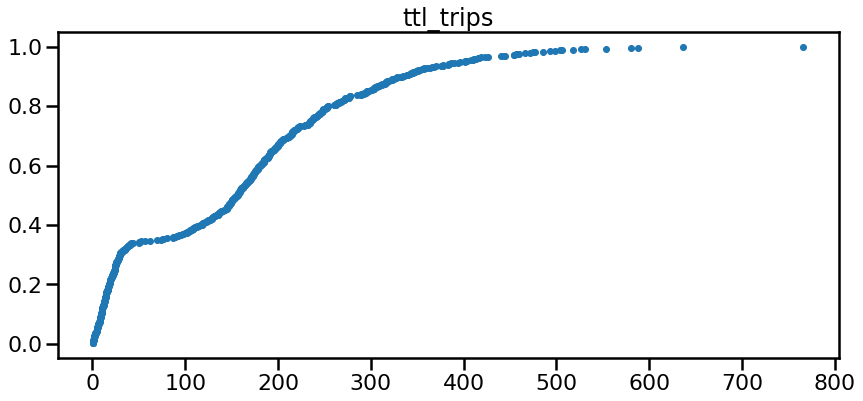

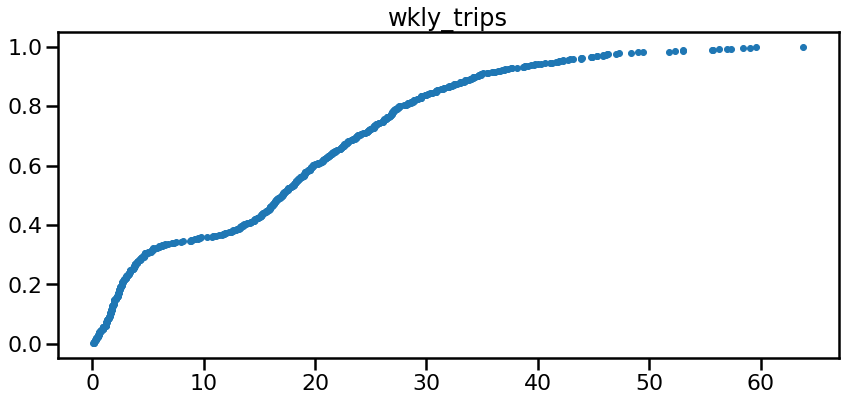

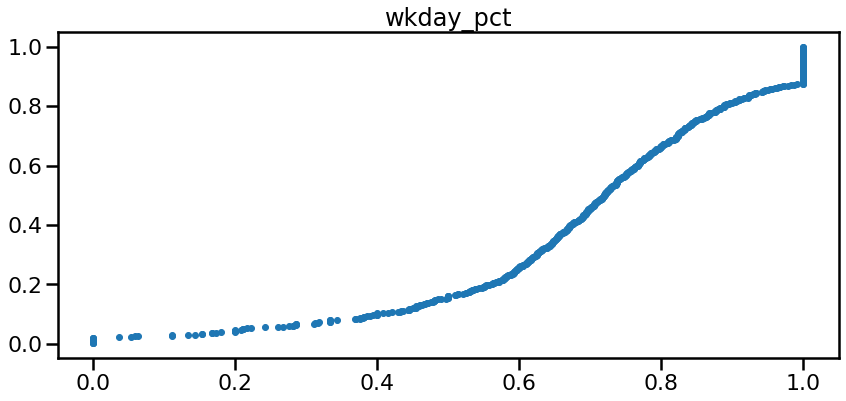

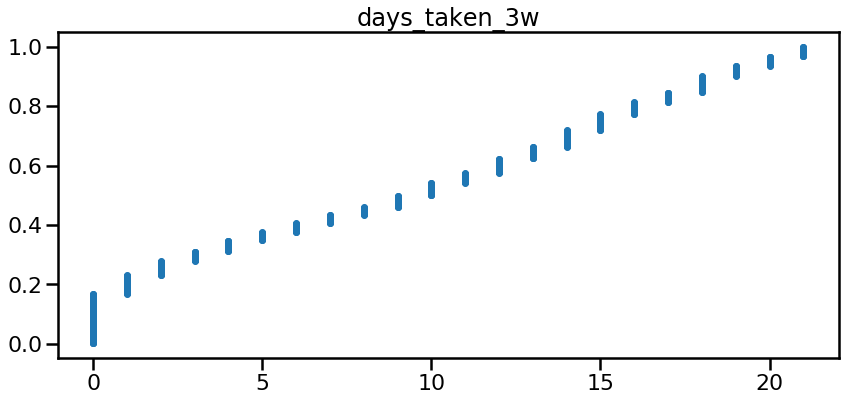

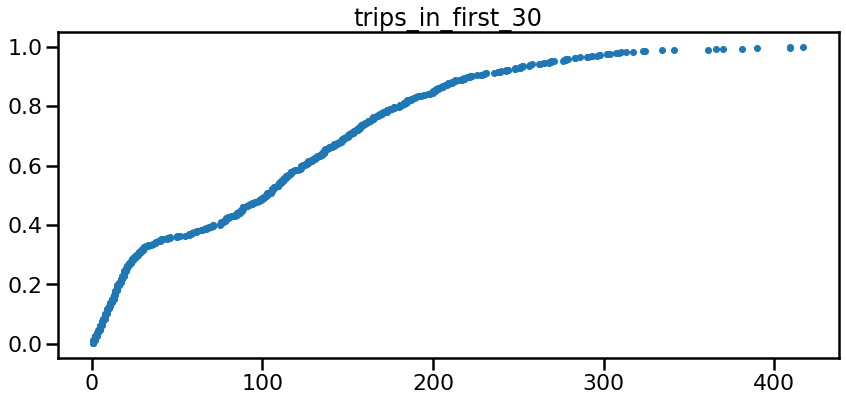

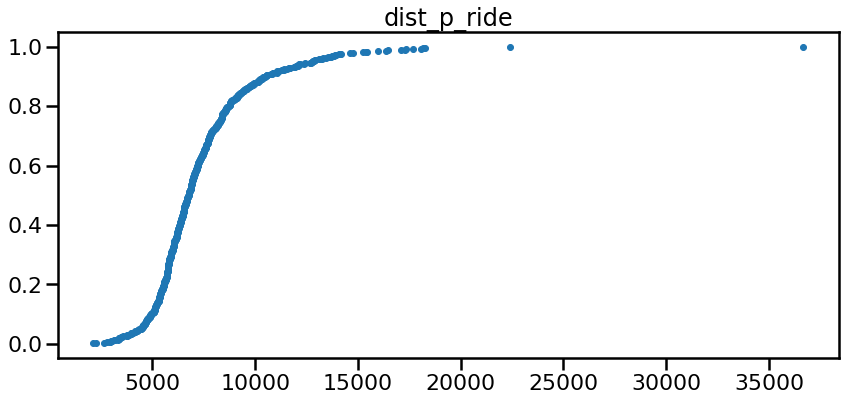

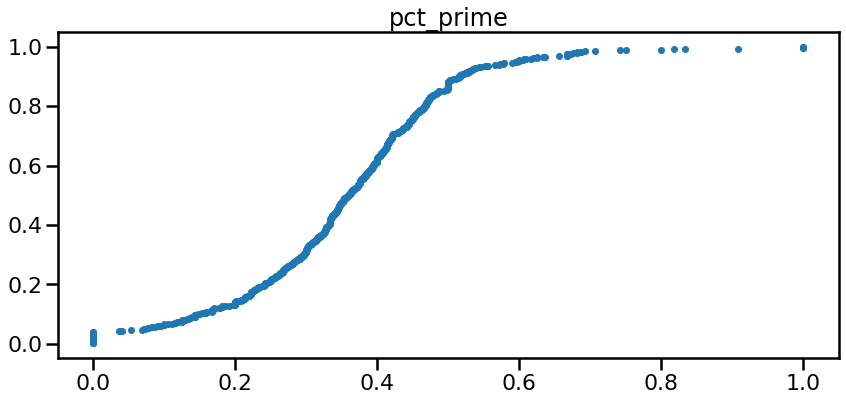

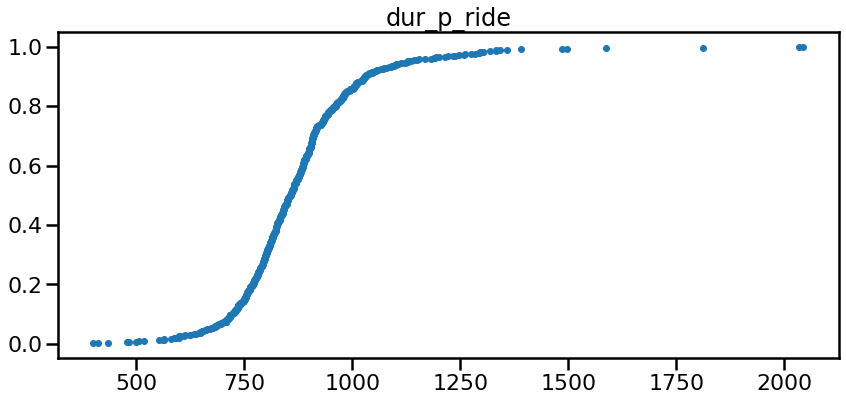

In [58]:

cols = ['weeks_active', 'ttl_trips','wkly_trips','wkday_pct','days_taken_3w', 'trips_in_first_30',
        'dist_p_ride','pct_prime', 'dur_p_ride']
for col in cols:
    plot_ecdf(ttl_rides_df[col], col)

In [59]:
ttl_rides_df[ttl_rides_df.churned == 'churned']['weeks_active'].mean()

6.330188679245283

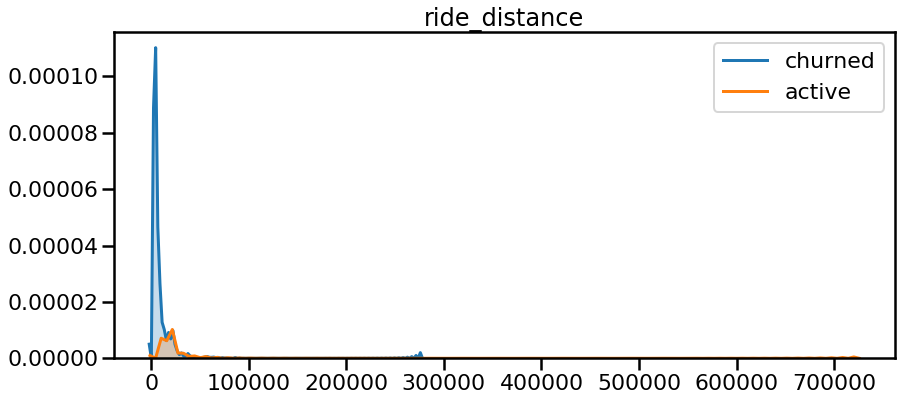

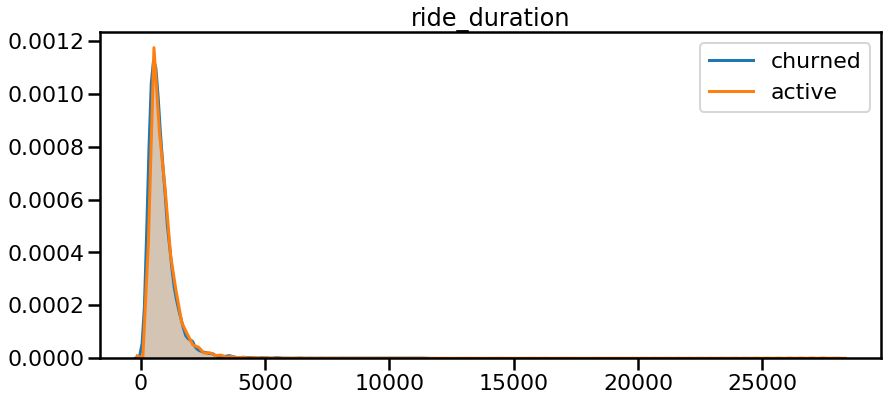

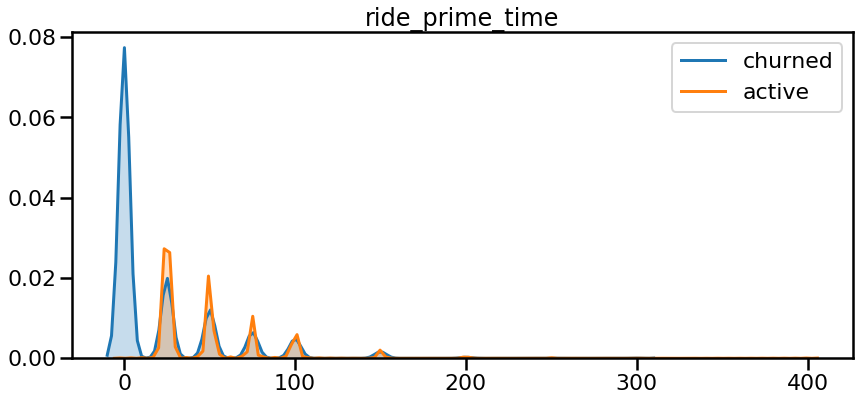

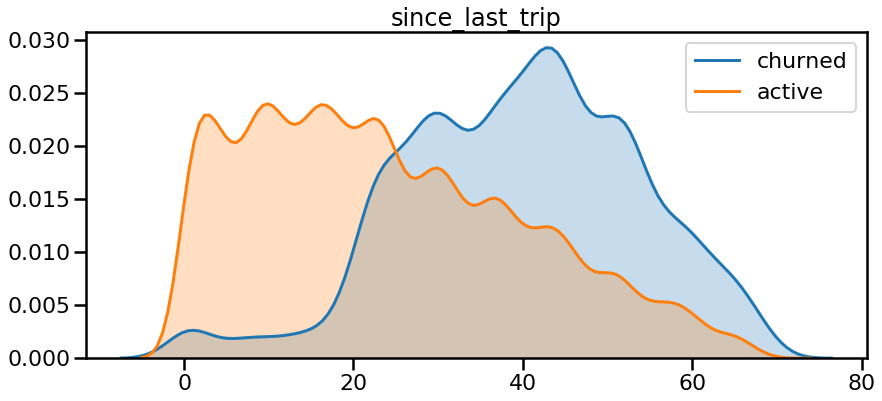

In [60]:
cols = ['ride_distance', 'ride_duration', 'ride_prime_time', 'since_last_trip']
for col in cols:
    for user in ['churned', 'active']:
        sns.kdeplot(df[df.churned == user][col], label = user, shade = True)
    plt.title(col)
    plt.show()

 

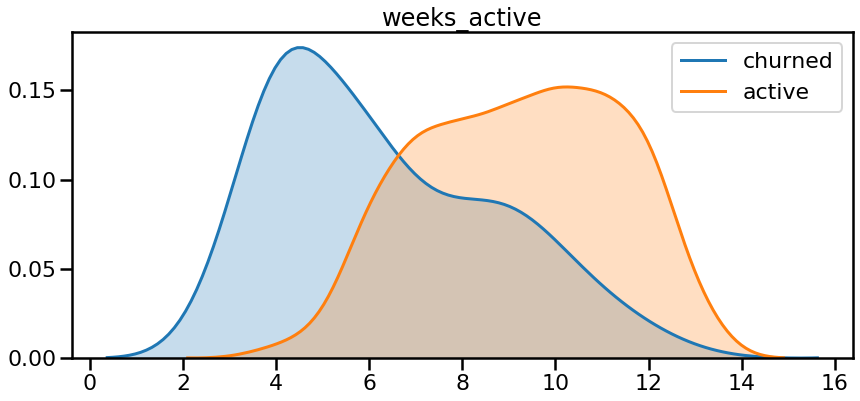

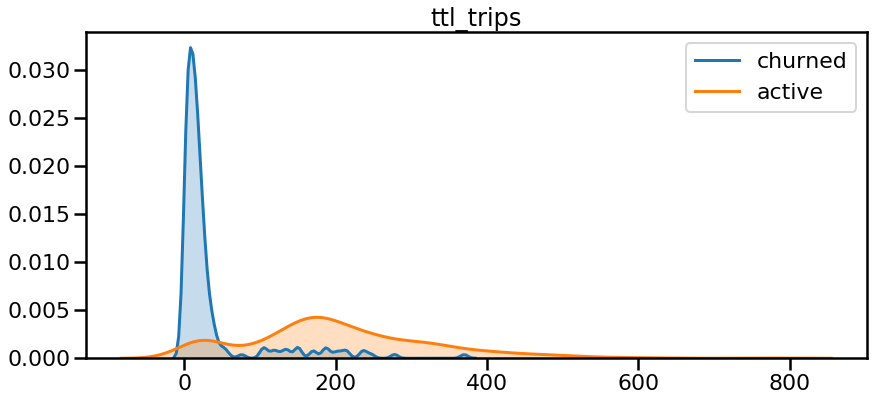

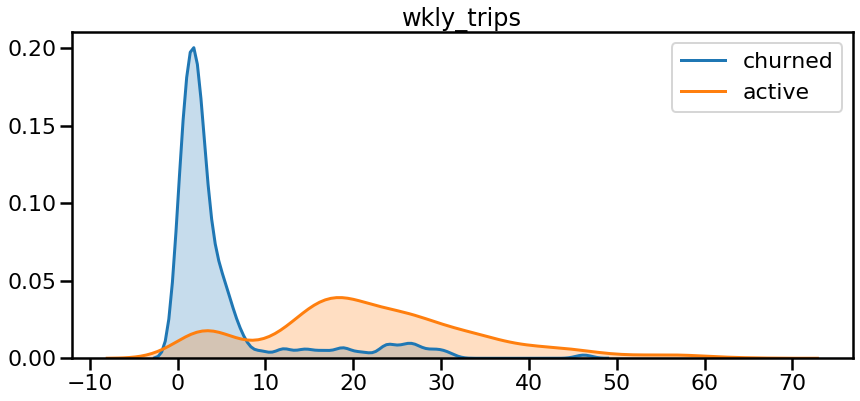

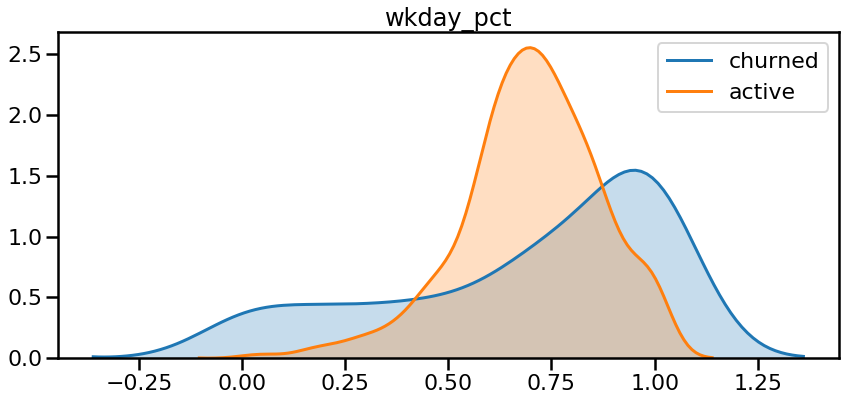

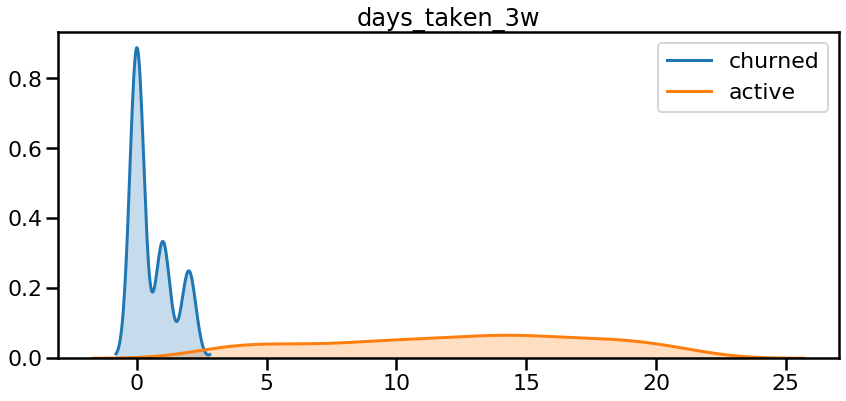

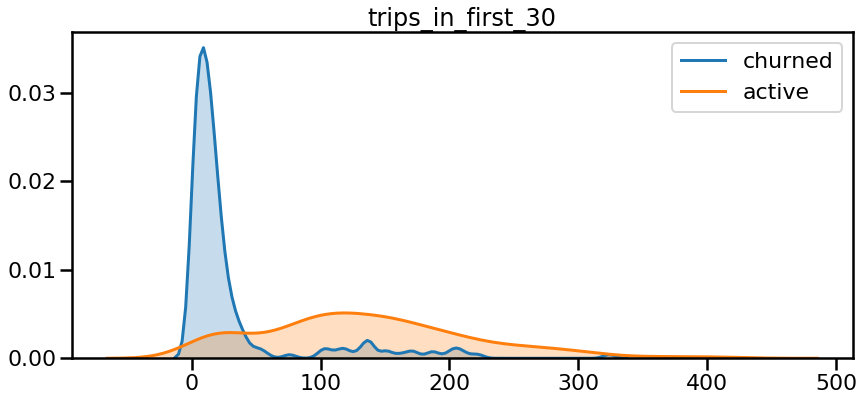

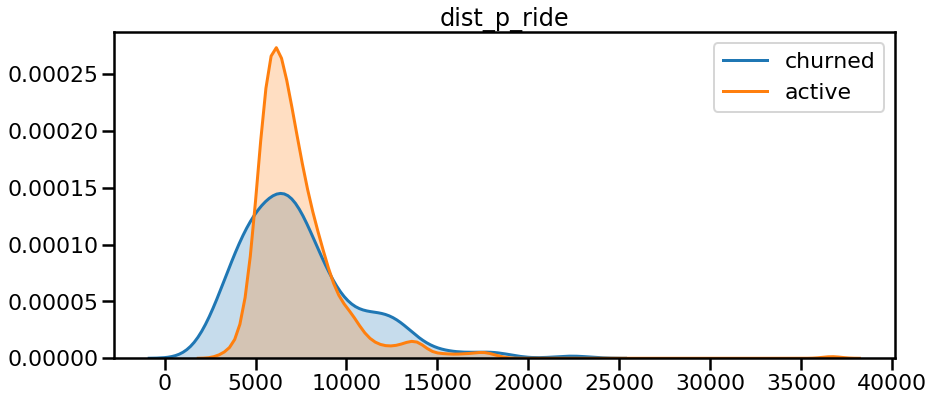

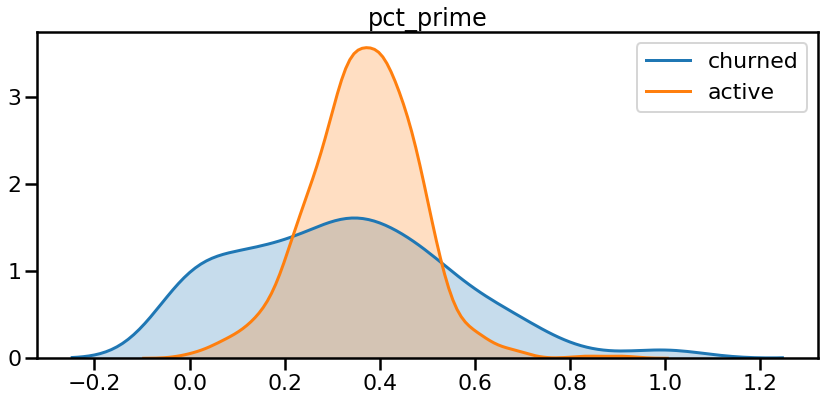

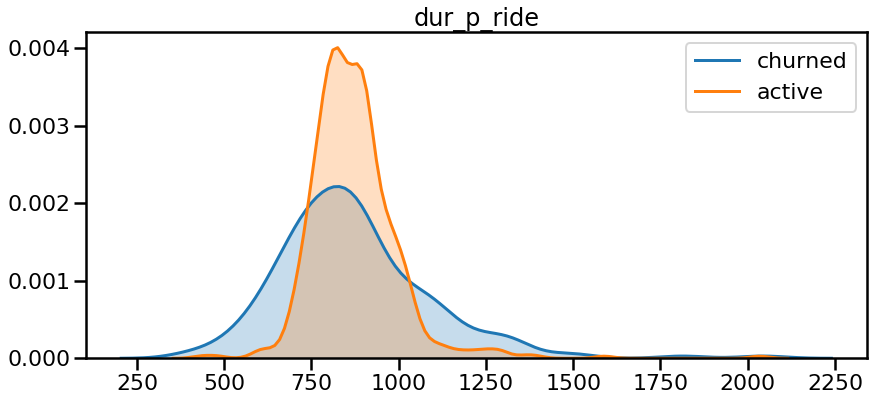

In [61]:
cols = ['weeks_active', 'ttl_trips','wkly_trips','wkday_pct','days_taken_3w', 'trips_in_first_30',
        'dist_p_ride','pct_prime', 'dur_p_ride']
for col in cols:
    for user in ['churned', 'active']:
        sns.kdeplot(ttl_rides_df[ttl_rides_df.churned == user][col], label = user, shade = True)
    plt.title(col)
    plt.show()


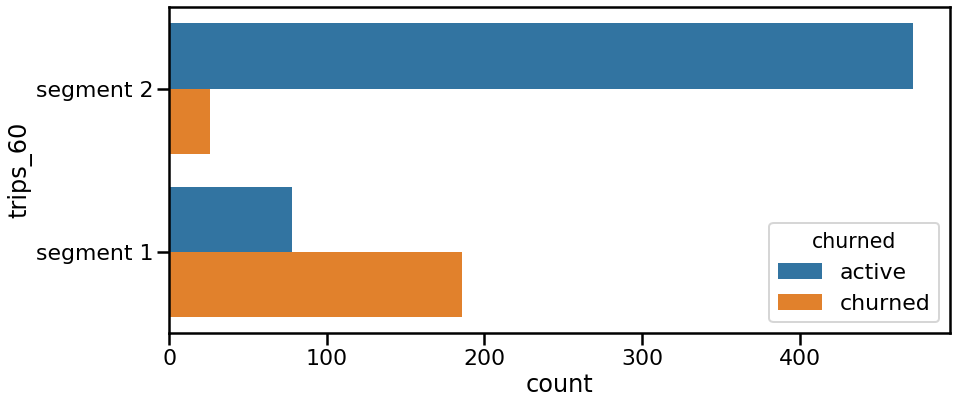

In [62]:
sns.countplot(y = 'trips_60', hue = 'churned', data = ttl_rides_df )
plt.show()

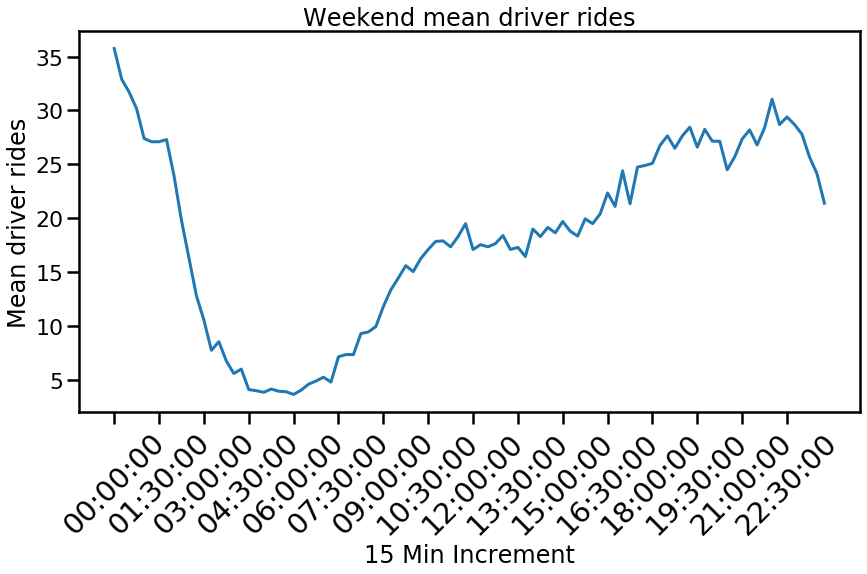

In [63]:
#aggregate data for a mean weekend by 15min interval
weekday = tsmp_df.groupby(['day_type','hour']).mean().loc['Weekend'].trips
fig = plt.figure(figsize = (14, 7))
plt.plot(weekday)
locs, labels = xticks()
plt.xlabel('15 Min Increment')
plt.ylabel('Mean driver rides')
plt.title('Weekend mean driver rides')
labelss = tsmp_df.groupby(['day_type','hour']).mean().loc['Weekend'].index[0::6]
plt.xticks(locs[::6], labelss, rotation = 45, fontsize = 'large')
plt.show()

 - peak drivers seem to be continually rise after 730am
 - I am curious if peak time follows this trend
 - will plot the weekday with PeakTime as a sanity check

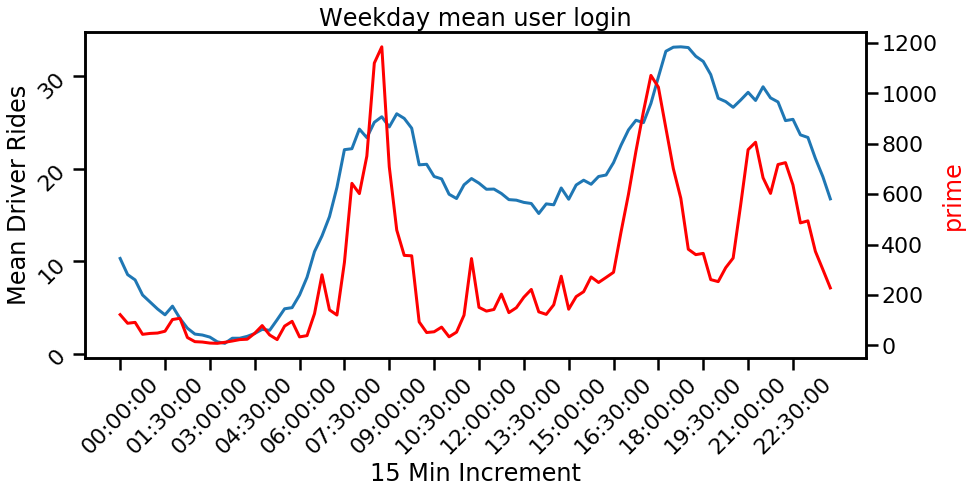

In [64]:
fig=plt.figure()
plt.plot(weekday)
locs, labels = xticks()
plt.close()

fig = plt.figure()
#aggregate data for a mean weekday by 15min interval
weekday = tsmp_df.groupby(['day_type','hour']).mean().loc['Weekday'].trips
weekday_pt = tsmp_df.groupby(['day_type','hour']).mean().loc['Weekday'].ride_prime_time

ax1 = fig.add_subplot(111)
ax1.plot(weekday)


ax1.set_xlabel('15 Min Increment')
ax1.set_ylabel('Mean Driver Rides')
ax1.tick_params(labelrotation = 45)
plt.title('Weekday mean user login')
ax2 = ax1.twinx()
ax2.set_ylabel('prime', color ='r')
ax2.plot(weekday_pt, color = 'r')

labelss = tsmp_df.groupby(['day_type','hour']).mean().loc['Weekday'].index[0::6]
plt.xticks(locs[::6], labelss, rotation = 45, fontsize = 'large')

plt.show()

### Create dataframe showcasing number of rides per week for comparison

In [65]:
from collections import defaultdict
activated_date= defaultdict(lambda:0)


for i in set(df.driver_id):
    dates = df[df.driver_id == i].ride_picked_up_at
    activated_date[i]=dates.iloc[0]

df['activated_date'] = df.driver_id.map(activated_date)

In [66]:
wk_n = df[['driver_id','activated_date']]
wk_n = wk_n.drop_duplicates()
wk_n['wk1'] = wk_n['activated_date'] + pd.to_timedelta('7D')
wk_n['wk2'] = wk_n['activated_date'] + pd.to_timedelta('14D')
wk_n['wk3'] = wk_n['activated_date'] + pd.to_timedelta('21D')
wk_n['wk4'] = wk_n['activated_date'] + pd.to_timedelta('28D')
wk_n['wk5'] = wk_n['activated_date'] + pd.to_timedelta('35D')
wk_n['wk6'] = wk_n['activated_date'] + pd.to_timedelta('42D')
wk_n['wk7'] = wk_n['activated_date'] + pd.to_timedelta('49D')
wk_n['wk8'] = wk_n['activated_date'] + pd.to_timedelta('56D')
wk_n['wk9'] = wk_n['activated_date'] + pd.to_timedelta('63D')

#wk_n['wk1_w_rides'] = wk_n['activated_date'] + pd.to_timedelta('7D')

In [67]:
wk1_rides = defaultdict(lambda:0)
wk2_rides = defaultdict(lambda:0)
wk3_rides = defaultdict(lambda:0)
wk4_rides = defaultdict(lambda:0)
wk5_rides = defaultdict(lambda:0)
wk6_rides = defaultdict(lambda:0)
wk7_rides = defaultdict(lambda:0)

for driver in set(df.driver_id):
    beg = wk_n[wk_n.driver_id ==driver].activated_date.iloc[0]
    end = wk_n[wk_n.driver_id ==driver].wk1.iloc[0]
    wk1_rides[driver] = len([x for x in df[df.driver_id == driver].ride_picked_up_at if beg<=x<=end])

for driver in set(df.driver_id):
    beg = wk_n[wk_n.driver_id ==driver].wk1.iloc[0]
    end = wk_n[wk_n.driver_id ==driver].wk2.iloc[0]
    wk2_rides[driver] = len([x for x in df[df.driver_id == driver].ride_picked_up_at if beg<=x<=end])
    
for driver in set(df.driver_id):
    beg = wk_n[wk_n.driver_id ==driver].wk2.iloc[0]
    end = wk_n[wk_n.driver_id ==driver].wk3.iloc[0]
    wk3_rides[driver] = len([x for x in df[df.driver_id == driver].ride_picked_up_at if beg<=x<=end])
    
for driver in set(df.driver_id):
    beg = wk_n[wk_n.driver_id ==driver].wk3.iloc[0]
    end = wk_n[wk_n.driver_id ==driver].wk4.iloc[0]
    wk4_rides[driver] = len([x for x in df[df.driver_id == driver].ride_picked_up_at if beg<=x<=end])
    
for driver in set(df.driver_id):
    beg = wk_n[wk_n.driver_id ==driver].wk4.iloc[0]
    end = wk_n[wk_n.driver_id ==driver].wk5.iloc[0]
    wk5_rides[driver] = len([x for x in df[df.driver_id == driver].ride_picked_up_at if beg<=x<=end])
    
for driver in set(df.driver_id):
    beg = wk_n[wk_n.driver_id ==driver].wk6.iloc[0]
    end = wk_n[wk_n.driver_id ==driver].wk7.iloc[0]
    wk6_rides[driver] = len([x for x in df[df.driver_id == driver].ride_picked_up_at if beg<=x<=end])
    
for driver in set(df.driver_id):
    beg = wk_n[wk_n.driver_id ==driver].wk8.iloc[0]
    end = wk_n[wk_n.driver_id ==driver].wk9.iloc[0]
    wk7_rides[driver] = len([x for x in df[df.driver_id == driver].ride_picked_up_at if beg<=x<=end])
    
wk_n['wk1_rides'] = wk_n.driver_id.map(wk1_rides)
wk_n['wk2_rides'] = wk_n.driver_id.map(wk2_rides)
wk_n['wk3_rides'] = wk_n.driver_id.map(wk3_rides)
wk_n['wk4_rides'] = wk_n.driver_id.map(wk4_rides)
wk_n['wk5_rides'] = wk_n.driver_id.map(wk5_rides)
wk_n['wk6_rides'] = wk_n.driver_id.map(wk6_rides)
wk_n['wk7_rides'] = wk_n.driver_id.map(wk7_rides)

In [68]:
wk_n = pd.merge(wk_n, ttl_rides_df[['churned']], left_on = 'driver_id',right_index = True)

In [69]:
wk_n_ = wk_n[['wk1_rides','wk2_rides', 'wk3_rides', 'wk4_rides',
       'wk5_rides', 'wk6_rides', 'wk7_rides', 'churned']]
wk_n_.reset_index(drop = True, inplace = True)

In [70]:
wk_n_.head()

,wk1_rides,wk2_rides,wk3_rides,wk4_rides,wk5_rides,wk6_rides,wk7_rides,churned
0,52,18,24,41,44,43,34,active
1,15,26,16,22,18,12,26,active
2,8,3,3,0,4,6,1,churned
3,65,5,58,50,31,0,0,churned
4,48,55,16,51,51,64,0,active


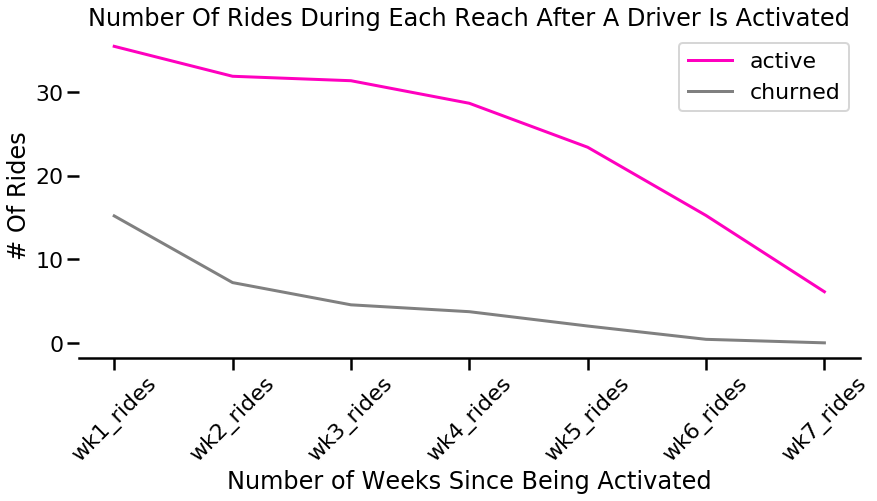

,wk1_rides,wk2_rides,wk3_rides,wk4_rides,wk5_rides,wk6_rides,wk7_rides
churned,,,,,,,
active,35.454545,31.878182,31.347273,28.652727,23.400000,15.247273,6.138182
churned,15.198113,7.231132,4.575472,3.754717,2.042453,0.452830,0.033019


In [71]:
g=sns.lineplot(data = wk_n_[wk_n_.churned =='active'].mean(), label = 'active' , color = '#FF00BF' )
sns.lineplot(data = wk_n_[wk_n_.churned =='churned'].mean(), label = 'churned', color = 'grey')
g.set_xticklabels(rotation = 45, labels = wk_n_[wk_n_.churned =='churned'].mean().index )

sns.despine(left=True, right=True)
_=plt.xlabel('Number of Weeks Since Being Activated')
_=plt.ylabel('# Of Rides')
_=plt.title('Number Of Rides During Each Reach After A Driver Is Activated')
plt.legend(loc = 1)

plt.legend()
_=plt.show()
display(wk_n_.groupby('churned').mean())

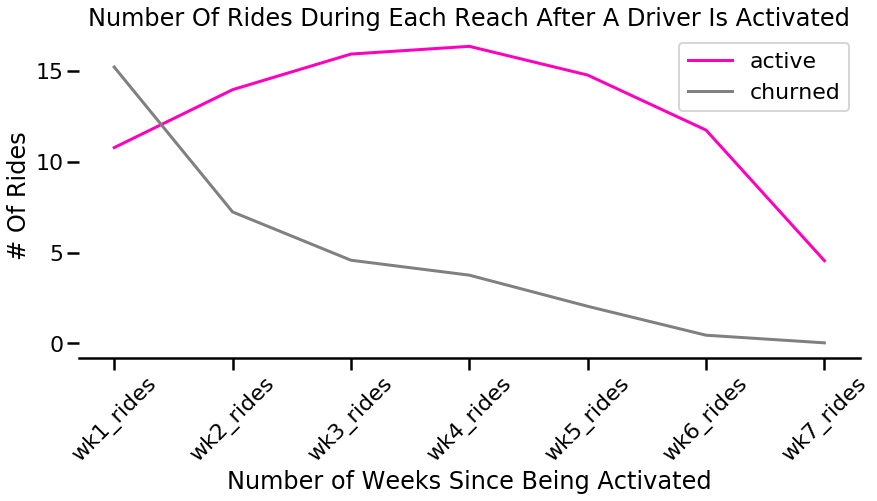

,wk1_rides,wk2_rides,wk3_rides,wk4_rides,wk5_rides,wk6_rides,wk7_rides
churned,,,,,,,
active,10.766467,13.952096,15.910180,16.335329,14.754491,11.730539,4.550898
churned,7.709302,3.162791,1.680233,1.389535,0.482558,0.308140,0.040698


In [72]:
g =sns.lineplot(data = wk_n_[(wk_n_.churned == 'active') & (wk_n_.wk1_rides <=20)].mean(), label = 'active', color = '#FF00BF' )
sns.lineplot(data = wk_n_[wk_n_.churned =='churned'].mean(), label = 'churned', color = 'grey')
g.set_xticklabels(rotation = 45, labels = wk_n_[wk_n_.churned =='churned'].mean().index )

sns.despine(left=True, right=True)
_=plt.xlabel('Number of Weeks Since Being Activated')
_=plt.ylabel('# Of Rides')
_=plt.title('Number Of Rides During Each Reach After A Driver Is Activated')
plt.legend(loc = 1)

plt.legend()
_=plt.show()
display(wk_n_[wk_n_.wk1_rides<=20].groupby('churned').mean())

## PairGrid and Correlation plots to observe trends among features

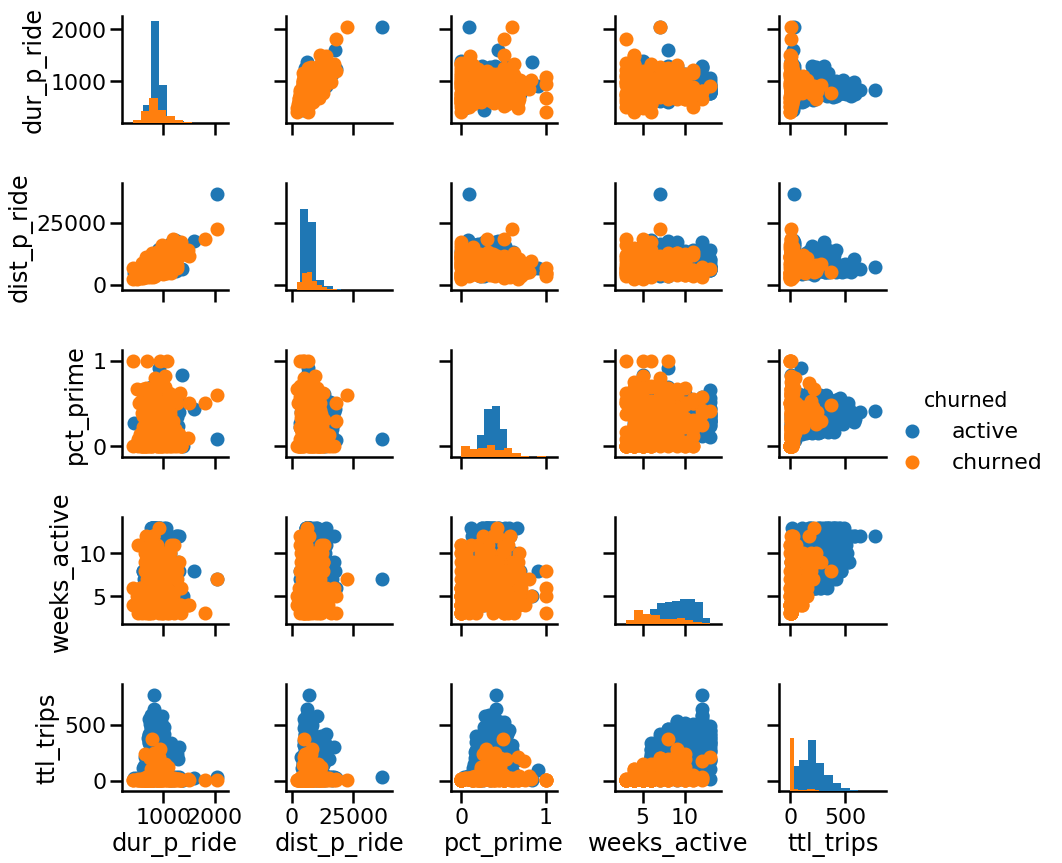

In [73]:
p = sns.PairGrid(ttl_rides_df,
                 x_vars = ['dur_p_ride', 'dist_p_ride', 'pct_prime', 'weeks_active', 'ttl_trips'],
                 y_vars = ['dur_p_ride', 'dist_p_ride', 'pct_prime', 'weeks_active', 'ttl_trips'],
                 hue = 'churned'
                )
p = p.map_diag(plt.hist)
p.map_offdiag(plt.scatter)
p.add_legend()

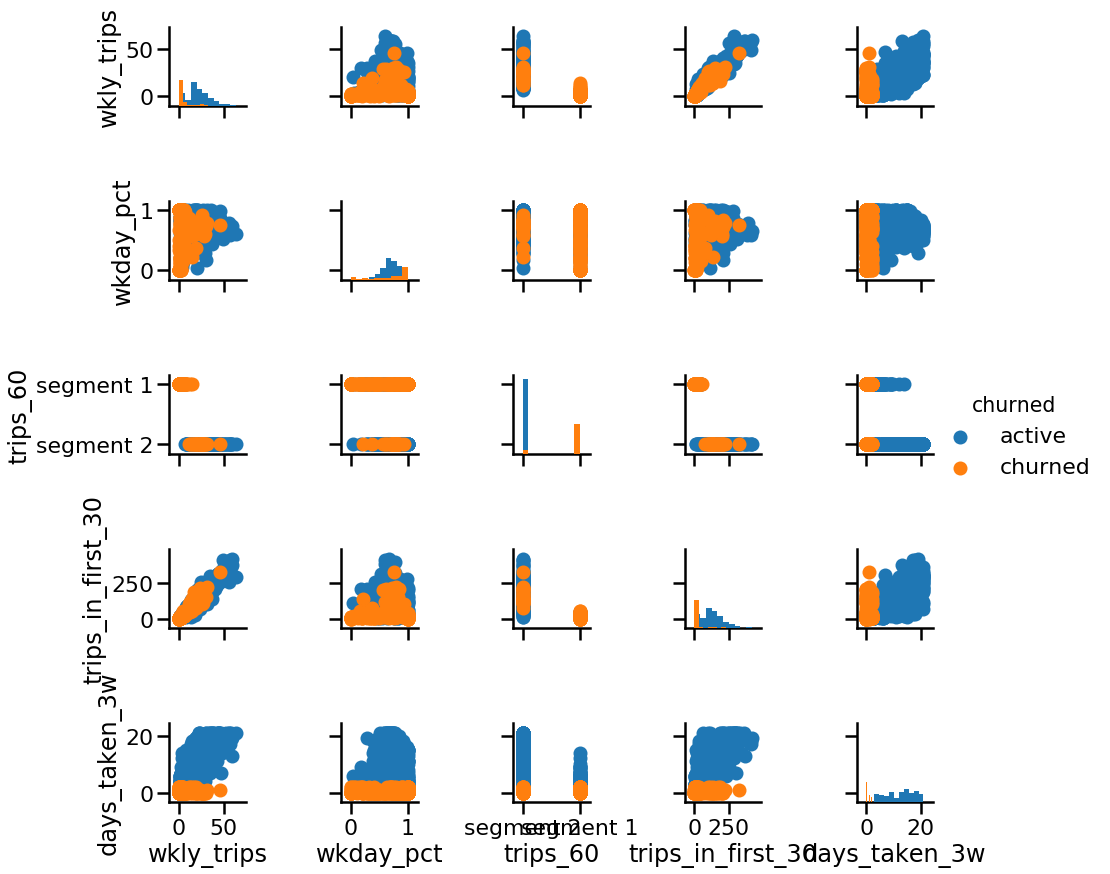

In [74]:
p = sns.PairGrid(ttl_rides_df,
                 x_vars = ['wkly_trips', 'wkday_pct', 'trips_60', 'trips_in_first_30','days_taken_3w'],
                 y_vars = ['wkly_trips', 'wkday_pct', 'trips_60', 'trips_in_first_30','days_taken_3w'],
                 hue = 'churned'
                )
p = p.map_diag(plt.hist)
p.map_offdiag(plt.scatter)
p.add_legend()

In [75]:
cor_df_ = ttl_rides_df.copy(deep = True)
cor_df_.replace({'churned':{'churned': 1, 'active':0}}, inplace = True)

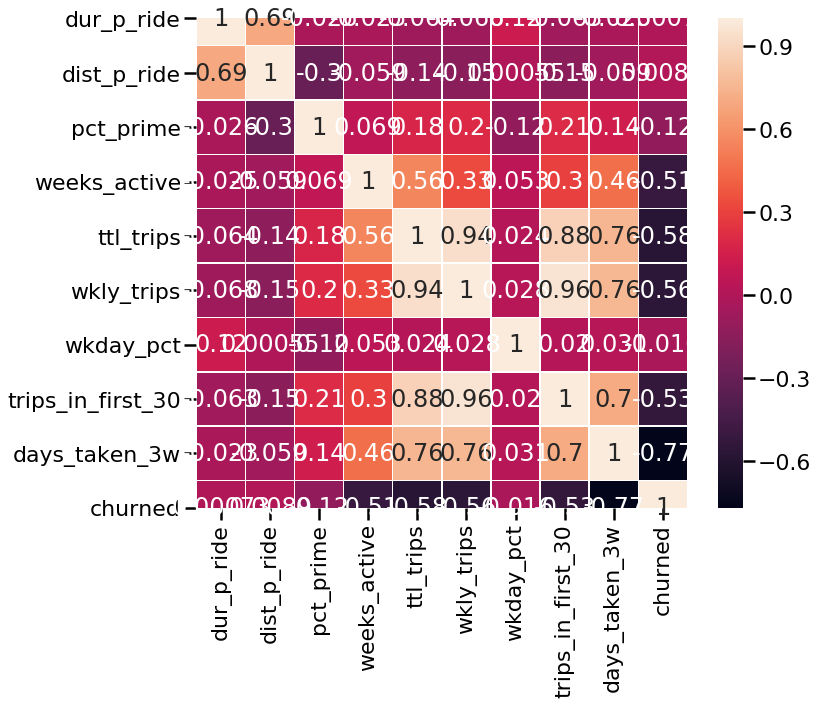

In [76]:
corr = cor_df_.corr()

fig, ax = plt.subplots(figsize = (11, 9))

sns.heatmap(corr, linewidths = .5, annot = True )

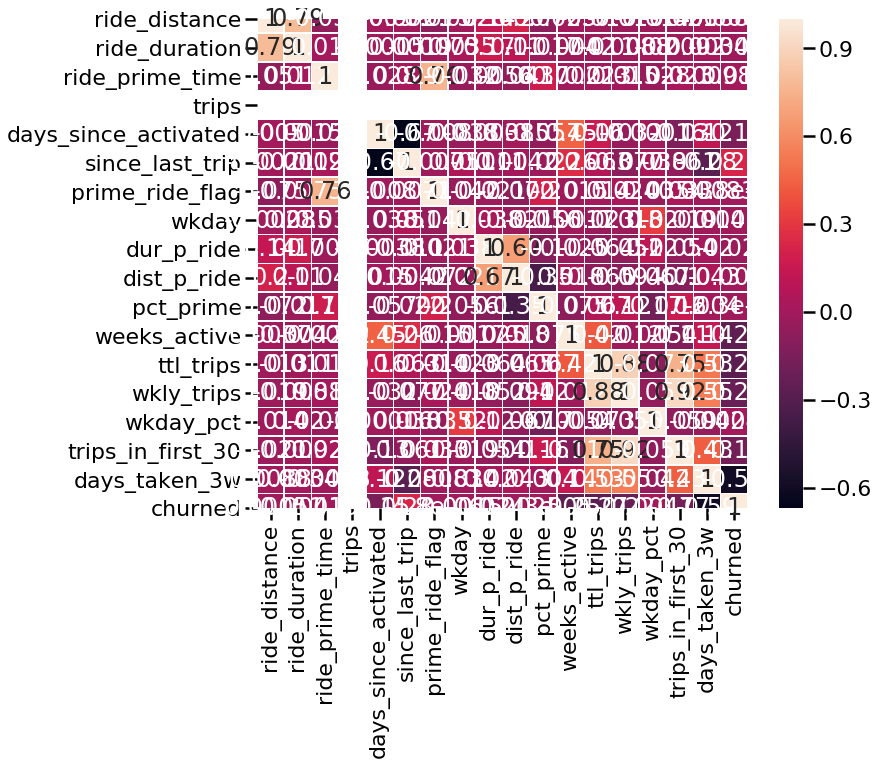

In [77]:
cor_df = df.copy(deep = True)
cor_df.replace({'churned':{'churned': 1, 'active':0}}, inplace = True)
corr = cor_df.corr()

fig, ax = plt.subplots(figsize = (11, 9))

sns.heatmap(corr, linewidths = .5, annot = True )

## Classifier to determine top features

In [78]:
#import relevent classifiers
from sklearn.ensemble import RandomForestClassifier


#import preprocessing, metrics & pipelines
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report


In [79]:
#set up the target variable
y = cor_df_['churned'].values


#set the x variables
X = cor_df_.drop(['trips_60','churned'], axis = 1)


In [80]:
#split the data to test & training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                    random_state = 5, stratify = y)


#build the pipline with upsampling & scaling the data
pipeline = Pipeline([('clf', RandomForestClassifier())
              ])

#paramters for tuning
parameters = [{'clf' : [ RandomForestClassifier(random_state = 5)],
               'clf__max_depth':[4, 3, None],
               'clf__n_estimators' : [50,100],
               'clf__max_features' : ['auto', 2, 4]},
]

#create the grid search object
cv = GridSearchCV(pipeline,
                  param_grid=parameters,
                  refit = True,
                  cv = 5, 
                  verbose = True,
                  n_jobs = -1)

#fit the data
cv.fit(X_train, y_train)


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    9.7s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('clf',
                                        RandomForestClassifier(bootstrap=True,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
                                                               min_impurity_split=None,
                                                               min_samples_leaf=1,
                                                               min_samples_split=2,
                      

In [81]:
#predict on the test set
y_pred = cv.predict(X_test)

#capture the prediction probabilities
y_predict_proba = cv.predict_proba(X_test)[:,1]


#Accuracy metrics
acc_score = cv.score(X_test, y_test)

print('The accuracy score is: {}'.format(acc_score))


#print the confusion matrix and classification report from the best model
print(classification_report(y_test, y_pred))

The accuracy score is: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       110
           1       1.00      1.00      1.00        43

    accuracy                           1.00       153
   macro avg       1.00      1.00      1.00       153
weighted avg       1.00      1.00      1.00       153



In [82]:
#obtain the feature importances from within the GridSearchCV, pipeline, & OneVsRest objects
fi = [x.feature_importances_ for x in cv.best_estimator_.steps[0][1].estimators_]
fi = np.mean(fi, axis = 0)

#place the feature importances in a dataframe
feature_importances = pd.DataFrame(fi,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.head(5)

,importance
days_taken_3w,0.568171
ttl_trips,0.165129
wkly_trips,0.091548
trips_in_first_30,0.087051
weeks_active,0.059646


 **Top 3 Predictors of churn**
 - **days_taken_3w:** Number of days a driver completed a ride in the previous 3 weeks
 - Total number of trips
 - Number of trips / week
 

# Part Two

 - Hypothesis 1: Doubling the number of rides in an activated driver's first week will have a high opportunity in additional rides
 - Hypothesis 2: Doubling the number of rides in an activated driver's second week from their first week will have a high opportunity in additional rides

### Hypothesis 1
- How big the opportunity
    - The opportunity is 45,444 additional rides among 762 drivers. Moving an average of 30 rides to 60. 
    - The average distance per ride is 7,034 meters. Resulting in a lift of 320KM
        - The lift in $$ would be your rate per M
    - Assuming all drivers hit this KPI goal

- What might be the longer-term consequences on the marketplace?
    - It would depend on how you set your KPI for this goal. Creating an incentive at 60 trips would have a long term negative effect. We already see a large drop in rides after the first few weeks, especially from the churned group.
        - There is a stigma of incentives being constantly harder to obtain. Doubling the amount of trips to achieve an incentive would could de-motivate drivers.
        - You would be overlooking the drivers that drive part time and making this incentive primarily for 'full time' drivers. A large portion of drivers see this as a 'part time' gig to add additional money to their pocket.
         - For lower ridership segments:
             - The churned drivers would move from **13 rides their first week to 60**. (Looking at the increase in time commitment is warranted)
            - Active drivers would need to increase from **40 rides their first week 60**.(Looking at the increase in time commitment is warranted)
        - Overall there is a downward trend in rides/wk. We will see an increase in rides, but a continued decrease per week.
        - The end result would be de-motivated drivers long term


In [83]:

wk1_mean = wk_n.wk1_rides.mean()
n_drivers = len(wk_n)
opp = (wk1_mean*2) * n_drivers
opp

45444.0

In [84]:
avg_dist = df.ride_distance.mean()
avg_dist

7034.367700338767

In [85]:
dist_lift = avg_dist * opp
dist_lift

319669805.7741949

### Hypothesis 2
- How big the opportunity
    - The opportunity is +20,404 rides. Moving an average of 25 rides to 52. 
    - The average distance per ride is 7,034 meters. Resulting in a lift of 144KM
        - The lift in $$ would be your rate per meter

- What might be the longer-term consequences on the marketplace?
    - The idea is a progressive incentive that focuses on maintaining/improving activity and adjusting goals to a quartile to award both parties. (A true quartile goaling system is recommended)
        - There is a stigma of incentives being constantly harder to obtain.
            - Having an incentive for lower rides on a second week will have the affect of limiting riders churing after the first week.
            - Seeing that the goal is not unachieavable for all groups will exacerbate the current stigma. Goals will be based on the driver's own performance.
        - You would be overlooking the drivers that drive part time and making this incentive primarily for 'full time' drivers. A large portion of drivers see this as a 'part time' gig to add additional money to their pocket.
            - The high ridership drivers will not be penalized with a very large goal
            - The high ridership drivers segment shows a decline after week 1, this will promote an overall increase after week 1. Their rides for week two would move from **38 to 65**, 19 more rides than the previous week.
            - The lower ridership drivers segment will have a goal that is more realistic. They drivers would need to increase from **8 to 18**, 9 more rides than the previous week.
        - The end result would be more attainable goals based on performance for drivers
        - Potentially addressing movement in other features that affect churn

In [86]:
wk_n_.wk1_rides.mean()

29.818897637795274

In [87]:
wk1_mean_l20 = wk_n_[wk_n_.wk1_rides < 20].wk1_rides.mean()
wk2_mean_l20 = wk_n_[wk_n_.wk1_rides < 20].wk2_rides.mean()
lift_l20 = (wk1_mean_l20 * 2) - wk2_mean_l20
lift_l20

9.84984984984985

In [88]:
ride_lift_l = len(wk_n_[wk_n_.wk1_rides < 20]) * lift_l20
ride_lift_l

3280.0

In [89]:
wk1_mean_m20 = wk_n_[wk_n_.wk1_rides > 20].wk1_rides.mean()
wk2_mean_m20 = wk_n_[wk_n_.wk1_rides > 20].wk2_rides.mean()
lift_m20 = (wk1_mean_m20 * 1.7) - wk2_mean_m20
lift_m20

40.48368794326242

In [90]:
ride_lift_m = len(wk_n_[wk_n_.wk1_rides > 20]) * lift_m20
ride_lift_m

17124.600000000002

In [91]:
total_lift = ride_lift_m + ride_lift_l
total_lift

20404.600000000002

In [92]:
ttl_wk2_rides = wk_n_.wk2_rides.sum() + total_lift
ttl_wk2_rides

39470.600000000006

In [93]:
ttl_wk2_rides/len(wk_n_)

51.798687664042

In [94]:
wk_n_.wk2_rides.mean()

25.020997375328083

In [95]:
wk_n_[wk_n_.wk1_rides > 20].mean()

wk1_rides    46.330969
wk2_rides    38.278960
wk3_rides    36.087470
wk4_rides    32.122931
wk5_rides    25.427896
wk6_rides    15.295508
wk7_rides     6.184397
dtype: float64

In [96]:
wk_n_[wk_n_.wk1_rides <=20].mean()

wk1_rides    9.215339
wk2_rides    8.477876
wk3_rides    8.690265
wk4_rides    8.752212
wk5_rides    7.513274
wk6_rides    5.935103
wk7_rides    2.262537
dtype: float64

**If the goal is to reduce churn AND improving the number of rides given by drivers** . I have more confidence in the second hypothesis based on the data.

The data shoes that active drivers frequently driving. They have less time between rides.
When focusing on the less frequent active rider - we see that their weekly rides grow for the first week.

If we focus too much on doubling the first week - we may see riders continue to churn.

Supporting & providing an incentive to maintaining or improving the numer of rides or the number of days giving rides week over week may keep drivers from churning. 

Finally, suppose the team wants to test the following hypothesis: *“eliminating the Prime Time
feature will decrease driver churn”*. Design an experiment to do so. Your design should include:

- **How you will divide observational units into control and treatment, and a description of the treatment and control conditions.**
    - **Assumption:** The total fare (with prime time) is shown to the rider, however on the driver app the feature displaying Prime Time is turned off
    - I'd randomly select a subset of drivers and randomly assign them to the control and treatment groups.

- **What are some potential second-order effects on the experience of drivers and passengers during this experiment.**
    - Any conversation that may happen about Prime Time pricing when a rider enters the car. Tests that are impacted by the network effect of users are difficult to control.
- **What are the primary and secondary metrics you will track.**
    - Response variable would be a ride given
    - The experimental unit would be driver/days ( observing the sum of rides per day for each driver)
- **How long you will run the experiment and how you will choose the winning variant.**
    - The test will run for one month
    - Verify the data was sufficiently random by segmenting the data by the variant to determine if there was any bias against any one group.
    - Observe the total sum of rides per day/driver and churn for both groups
        - determine statistical significance between the two groups.
        - If churn is signicantly lower in the variant group (no Prime Time feature) vs. the control group than we reject the null hypothesis and determine the variant group as the 'winning variant'

## Considerations:
 - After this analysis - I would dig deeper into more engineerd features that look at consistency.
     - For example: How many does does it take someone to become 'activated? Is there a dramatic difference here among churned/activated drivers?
 - Dig deeper into the active segment of drivers that have a similar ride count (similar statistical means) and investigate other features that may show some variability.
 - I used few comparisons in this data - I would go back to ensure they were statistically different

Resources: <br />
https://www.cnbc.com/2017/04/20/only-4-percent-of-uber-drivers-remain-after-a-year-says-report.html <br />
https://www.theinformation.com/articles/how-uber-will-combat-rising-driver-churn <br />
https://therideshareguy.com/7-reasons-why-uber-and-lyft-drivers-are-quitting-rideshare/ <br />
https://www.wsj.com/articles/uber-and-lyft-face-tough-test-of-finding-and-keeping-drivers-11557673863 <br />
https://blog.lyft.com/posts/for-drivers-from-drivers-new-features-and-improvements-coming-every-month <br />
https://www.bizjournals.com/sanfrancisco/blog/techflash/2015/10/uber-lyft-drivers-leave-tech-startup-churn-vc.html <br />
https://about.bnef.com/blog/lyft-stacks-peers-four-graphics/ <br />
https://www.cbinsights.com/research/report/how-uber-makes-money/ <br />